In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
module = fc.sixb.feynnet

In [3]:
def use_train(f, tag=''):
    return f.replace('ntuple',f'split_0_reweight{tag}_train_ntuple')

In [4]:
signal = ObjIter([Tree(use_train(f, tag='_sixb'), report=False) for f in tqdm(module.full_signal_6b_list)])
bkg = ObjIter([Tree(map(use_train, module.Run2_UL18.QCD_B_List))])

100%|██████████| 16/16 [00:04<00:00,  3.49it/s]


In [5]:
(signal + bkg).apply( lambda t : (t.sample, 4*len(t)))

[('MX_700_MY_300', 20240), ('MX_800_MY_300', 22040), ('MX_800_MY_350', 24768), ('MX_900_MY_300', 24860), ('MX_900_MY_400', 23864), ('MX_1000_MY_350', 23272), ('MX_1000_MY_450', 25776), ('MX_1200_MY_450', 28620), ('QCD', 5741956)]

In [6]:
(signal).apply( lambda t : 4*len(t)).npy.sum()

193440

In [10]:
5741956/1024/2

2803.689453125

In [7]:
193440/1024

188.90625

In [84]:
def get_mu_sig(h):
    print(h.stats.mean,',', 1/h.stats.stdv)
    return f'${h.stats.mean:0.2f}\pm{h.stats.stdv:0.2f}$'

 50%|█████     | 2/4 [00:00<00:00,  7.24it/s]

90.1863744404036 , 0.02029493270070353
14.093781738809295 , 0.1328388505801563


100%|██████████| 4/4 [00:00<00:00,  7.06it/s]

-0.0034282617920364123 , 1.0299963534769598
0.002795325282884 , 0.5506874113177629


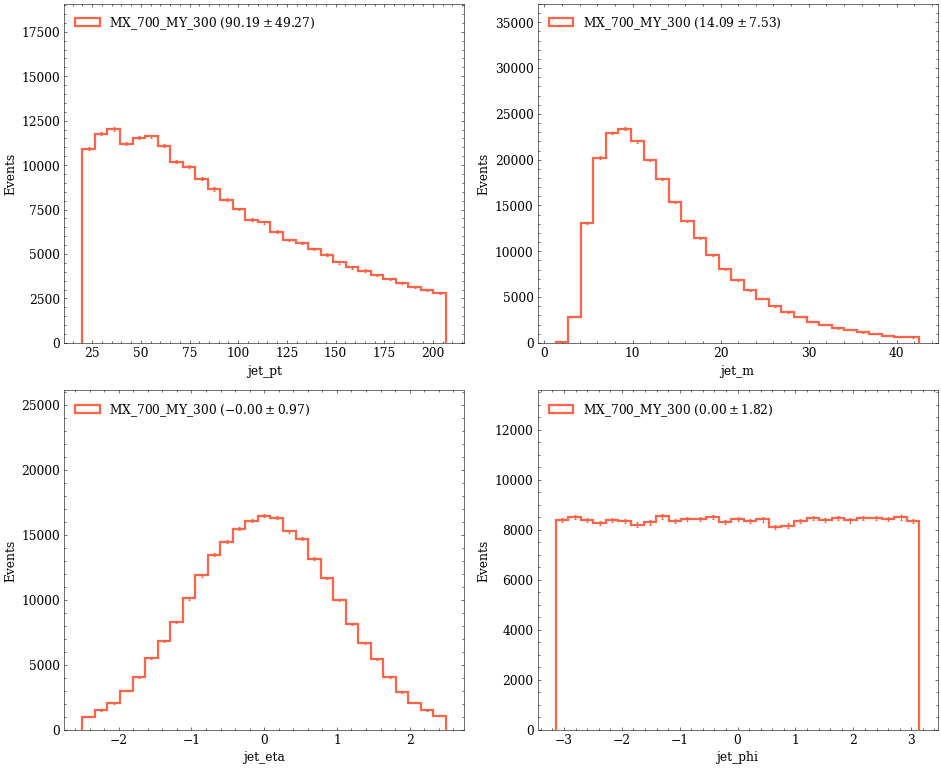

In [85]:
study.quick_region(
    signal,
    varlist=['jet_pt','jet_m','jet_eta','jet_phi'],
    scale=lambda t:t.dataset_norm_abs_scale/t.scale,
    lumi=None,

    h_label_stat=get_mu_sig,
    legend=True,
)

 50%|█████     | 2/4 [00:00<00:00,  6.67it/s]

4.52145307825366 , 1.39125118908511
2.530509195582204 , 1.836500582563202


100%|██████████| 4/4 [00:00<00:00,  6.59it/s]

-0.0018214905062197532 , 1.4137388500345944
0.00021980109183276914 , 1.4148074556953831


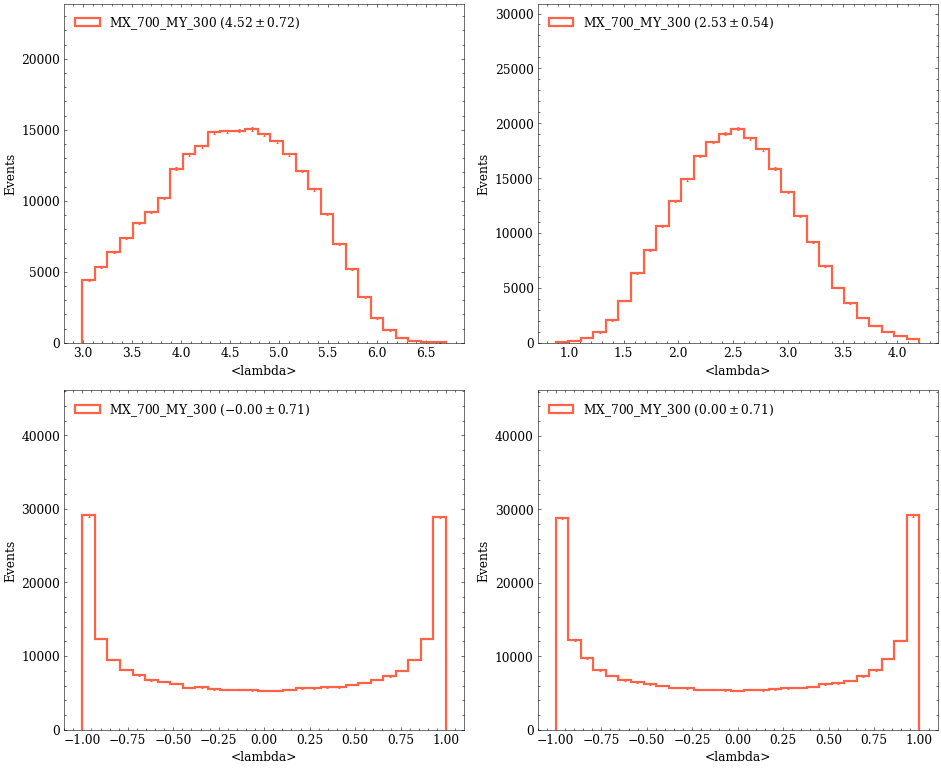

In [86]:
study.quick_region(
    signal,
    varlist=[lambda t : np.log(t.jet_pt),lambda t : np.log(t.jet_m), lambda t : np.cos(t.jet_phi), lambda t : np.sin(t.jet_phi)],
    scale=lambda t:t.dataset_norm_abs_scale/t.scale,
    lumi=None,

    h_label_stat=get_mu_sig,
    legend=True,
)

100%|██████████| 1/1 [00:05<00:00,  5.54s/it]


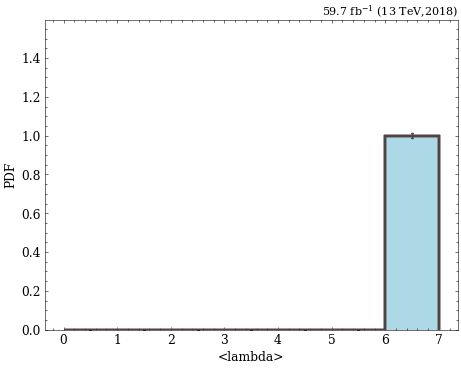

In [80]:
study.quick(
    signal + bkg,
    varlist=[lambda t : ak.count(t.jet_pt, axis=1)],
    efficiency=True
)

In [8]:
(signal + bkg).apply(lambda t: (t.sample, len(t)))

[('MX_700_MY_300', 2627065), ('MX_1000_MY_450', 3258442), ('MX_1200_MY_500', 3507074), ('QCD', 1231185)]

In [33]:
def random_sample(t, frac=0.2):
    rand_mask = np.random.random(size=len(t)) < frac
    t.extend(random_mask=rand_mask)



In [34]:
(signal+bkg).apply(random_sample)

[None, None, None, None]

100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


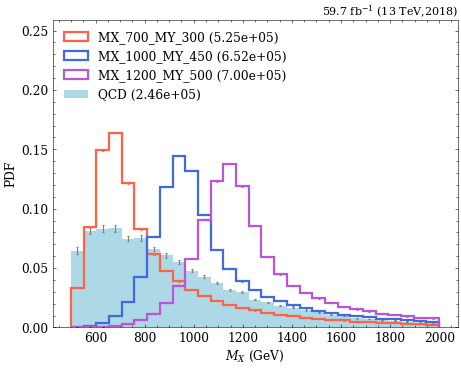

In [37]:
study.quick(
    signal + bkg,
    masks=lambda t : t.random_mask,
    varlist=['X_m'],

    efficiency=True,
    h_label_stat=lambda h : f'{len(h.array):0.2e}',
    legend=True,
)

In [39]:
trigger = 'HLT_PFHT330PT30_QuadPFJet_75_60_45_40_TriplePFBTagDeepCSV_4p5'

In [48]:
trg_pt = [75,60,45,40]

def trg_pt_mask(t, trg_pt=trg_pt):
    jet_pt = t.jet_pt

    mask = jet_pt[:,0] > 0
    for i, pt_ths in enumerate(trg_pt):
        mask = mask & (jet_pt[:,i] > pt_ths)
    
    return mask

def trg_ht_mask(t):
    jet_pt = t.jet_pt 

    jet_ht = ak.sum(jet_pt[jet_pt > 30], axis=1)
    return jet_ht > 330


In [52]:
(signal + bkg).apply(lambda t: (t.sample, ak.mean(trg_pt_mask(t) & trg_ht_mask(t))))

[('MX_700_MY_300', 0.924493303363259), ('MX_1000_MY_450', 0.9929002879290164), ('MX_1200_MY_500', 0.9972797836601109), ('QCD', 0.8804265808956412)]

100%|██████████| 2/2 [00:04<00:00,  2.10s/it]


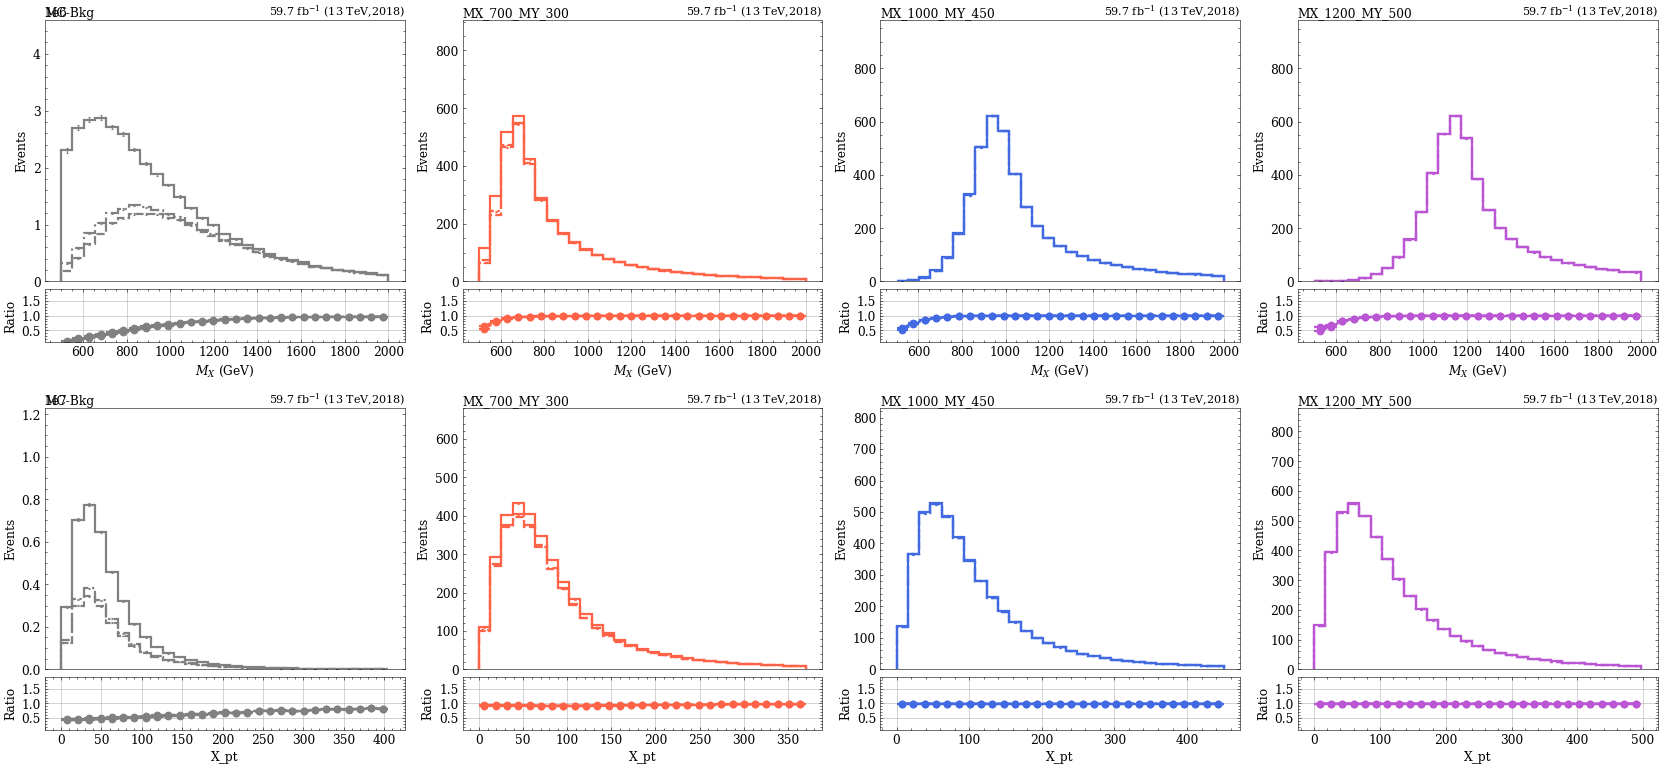

In [54]:
study.compare_masks(
    signal,bkg, 
    masks=[None, trg_pt_mask, lambda t : trg_pt_mask(t) & trg_ht_mask(t)],
    varlist=['X_m','X_pt'],
    # efficiency=True,
    ratio=True, r_inv=True,
)

In [56]:
def trg_mask(t):
    return trg_pt_mask(t) & trg_ht_mask(t)

100%|██████████| 2/2 [00:03<00:00,  1.72s/it]


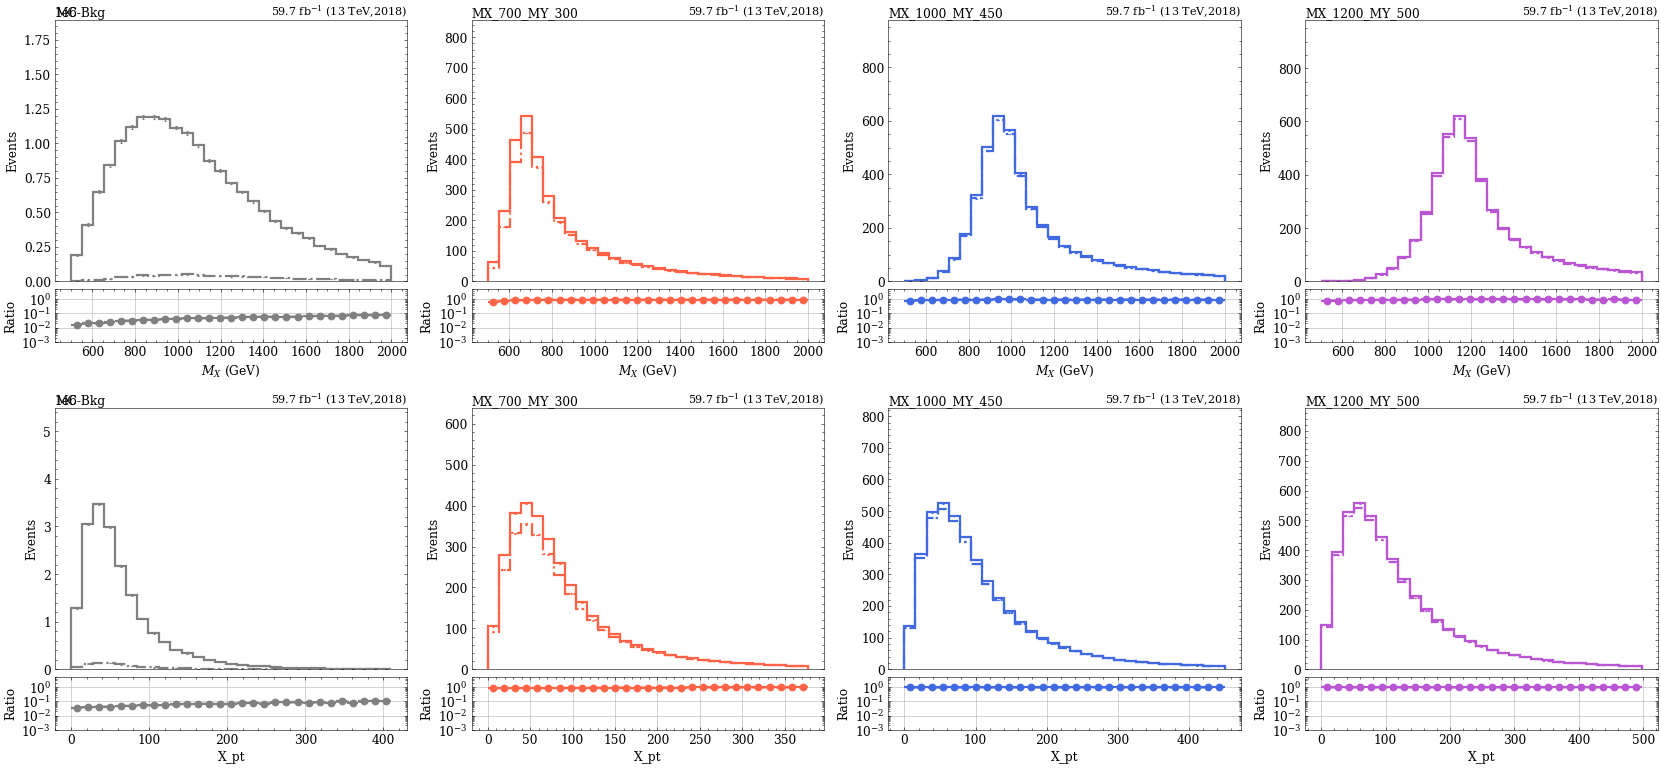

In [59]:
study.compare_masks(
    signal,bkg, 
    masks=[trg_mask, lambda t : trg_mask(t) & (t[trigger]==1)],
    varlist=['X_m','X_pt'],
    # efficiency=True,
    ratio=True, r_inv=True, r_log=True, r_ylim=(1e-3,5e0)
)

100%|██████████| 2/2 [00:03<00:00,  1.79s/it]


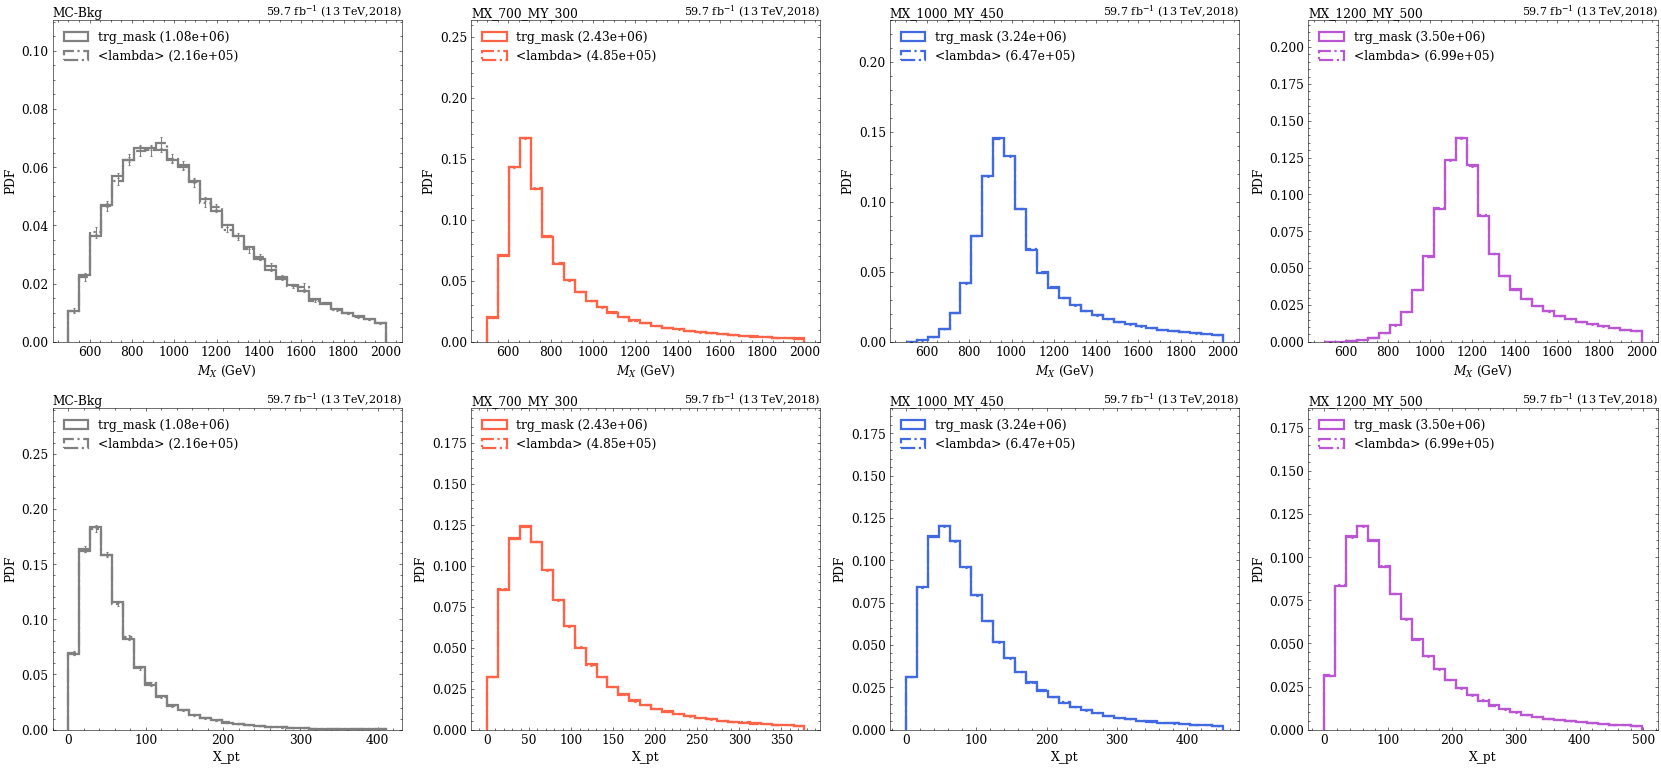

In [61]:
study.compare_masks(
    signal,bkg, 
    masks=[trg_mask, lambda t : trg_mask(t) & (t.random_mask)],
    varlist=['X_m','X_pt'],
    efficiency=True,
    legend=True,
    h_label_stat=lambda h : f'{len(h.array):0.2e}'
    # ratio=True, r_inv=True, r_log=True, r_ylim=(1e-3,5e0)
)